In [ ]:
# https://fred.stlouisfed.org/series/IPG2211A2N
# Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2) (IPG2211A2N)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import itertools
from statsmodels.tsa.seasonal import STL

In [5]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

file_path = '/content/drive/My Drive/Codebasics/Time Series Learning Material/data.csv'

df = pd.read_csv(file_path, parse_dates=[0], index_col=0, date_format = parser)


In [8]:
df.index.name = 'date'

In [9]:
'''
The NAICS code 2211,2 refers to the specific industries included:

NAICS 2211: Electric Power Generation, Transmission, and Distribution

NAICS 2212: Natural Gas Distribution

What Unit Is It In?
The unit for this series is an Index, with 2017 = 100. This means that the value of 100 on the index represents
the average monthly output of electric and gas utilities in the year 2017.
If the index value is, for example, 110, it means the output is 10% higher than the 2017 average.
If the index is 90, the output is 10% lower than the 2017 average.
'''

'\nThe NAICS code 2211,2 refers to the specific industries included:\n\nNAICS 2211: Electric Power Generation, Transmission, and Distribution\n\nNAICS 2212: Natural Gas Distribution\n\nWhat Unit Is It In?\nThe unit for this series is an Index, with 2017 = 100. This means that the value of 100 on the index represents\nthe average monthly output of electric and gas utilities in the year 2017.\nIf the index value is, for example, 110, it means the output is 10% higher than the 2017 average.\nIf the index is 90, the output is 10% lower than the 2017 average.\n'

In [10]:
df.rename(columns={'IPG2211A2N':'unit'}, inplace=True)

In [11]:
df = df.loc['2010-01-01':]

In [12]:
df

,unit
date,
2010-01-01,117.4737
2010-02-01,109.1060
2010-03-01,96.8805
2010-04-01,84.9776
2010-05-01,89.4931
...,...
2025-03-01,100.6731
2025-04-01,93.2445
2025-05-01,95.2159


In [13]:
start_date = datetime(int(df.index[0].split('-')[0]), int(df.index[0].split('-')[1]), int(df.index[0].split('-')[2]))
end_date = datetime(int(df.index[-1].split('-')[0]), int(df.index[-1].split('-')[1]), int(df.index[-1].split('-')[2]))

In [14]:
start_date

datetime.datetime(2010, 1, 1, 0, 0)

In [15]:
fig = px.line(df, x = df.index, y = 'unit',
              title = 'Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)',
              labels = {'unit': 'Index 2017 = 100'})

# Add vertical lines for each year
for year in range(int(start_date.year), int(end_date.year)):
    fig.add_vline(x = pd.to_datetime(f'{year}-01-01'), line = dict(color='black', width = 0.5, dash = 'dash'))
fig.update_xaxes(
    tickmode='linear',
    dtick="M12"
)
fig.show()

In [16]:
first_diff = df.diff()[1:]

In [17]:
fig = px.line(first_diff, x=first_diff.index, y='unit',
              title='Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)',
              labels={'unit': 'Index 2017 = 100'})

# Add vertical lines for each year with transparency
for year in range(int(start_date.year), int(end_date.year)):
    fig.add_vline(
        x=pd.to_datetime(f'{year}-01-01'),
        line=dict(color='rgba(0,0,0,0.8)', width=0.5, dash='dash')
    )

# Show all x-axis labels (one per year)
fig.update_xaxes(
    tickmode='linear',
    dtick="M12"
)

fig.show()

In [18]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [19]:
# CHeck for stationarity
perform_adf_test(first_diff)

ADF Statistic: -5.937947
p-value: 0.000000


In [20]:
perform_adf_test(df)

ADF Statistic: -1.162957
p-value: 0.689325


In [ ]:
# justifies first differencing

In [ ]:
# anomaly detect

In [21]:
df

,unit
date,
2010-01-01,117.4737
2010-02-01,109.1060
2010-03-01,96.8805
2010-04-01,84.9776
2010-05-01,89.4931
...,...
2025-03-01,100.6731
2025-04-01,93.2445
2025-05-01,95.2159


In [ ]:
# Checking for anomalies

In [22]:
# Convert the index to datetime
df.index = pd.to_datetime(df.index)

# Now check frequency
print(df.index.freq)          # might still be None
print(df.index.inferred_freq) # should infer something like 'D', 'M', etc.


None
MS


In [23]:
stl = STL(df)
result = stl.fit()

In [24]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

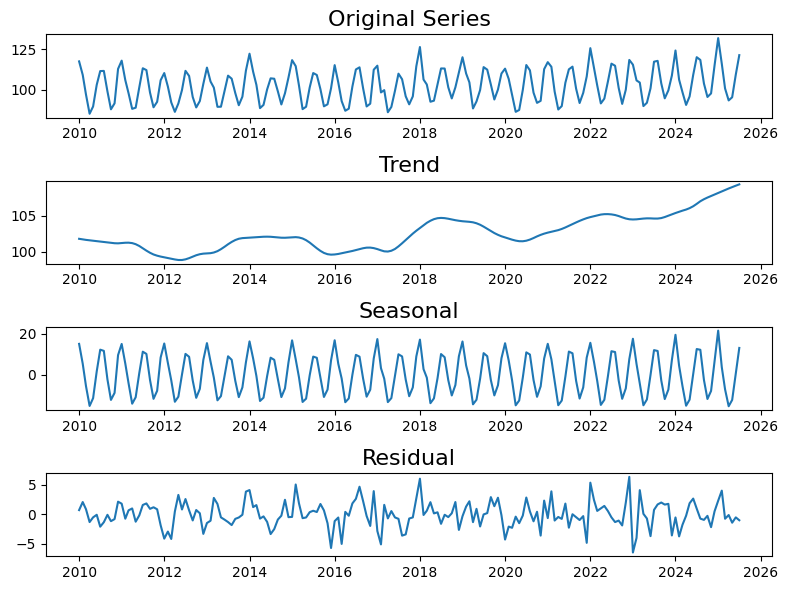

In [25]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

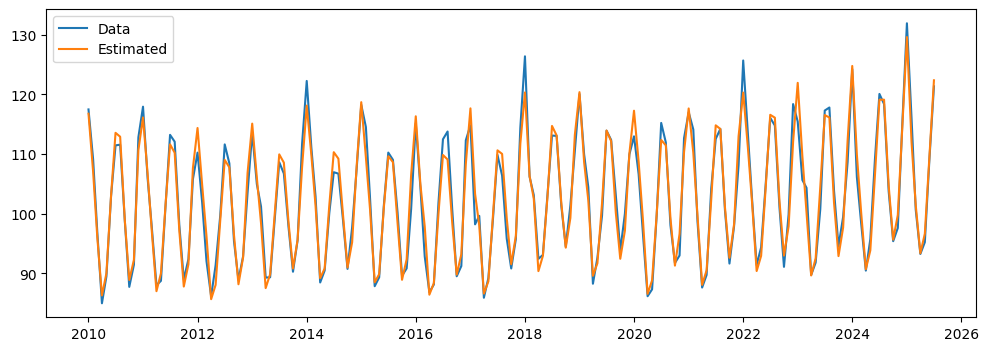

In [26]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df)
plt.plot(estimated)
plt.legend(('Data', 'Estimated'))

In [27]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

(np.float64(14610.0), np.float64(20270.0))

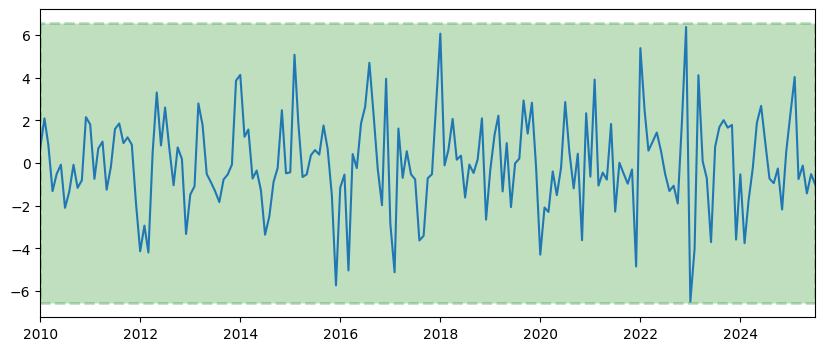

In [28]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2010,1,1), datetime(2025,7,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2010,1,1), datetime(2025,7,1))

In [29]:
anomalies = df[(resid < lower) | (resid > upper)]

In [30]:
anomalies

,unit
date,


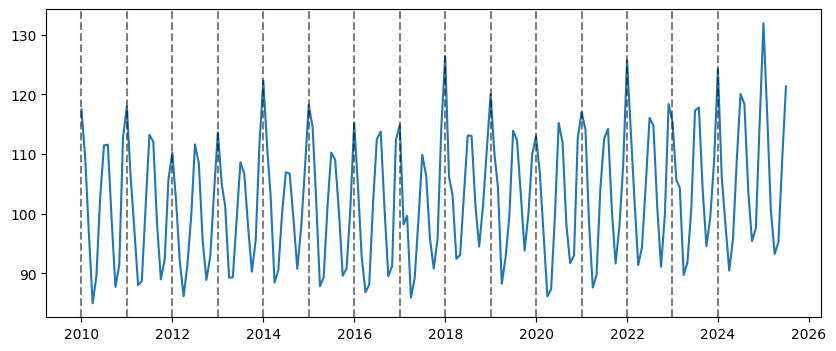

In [31]:
plt.figure(figsize=(10,4))
plt.plot(df)
for year in range(2010,2025):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

plt.scatter(anomalies.index, anomalies['unit'], color='r', marker='D')

In [32]:
# No anomalies detected at 3 sigma

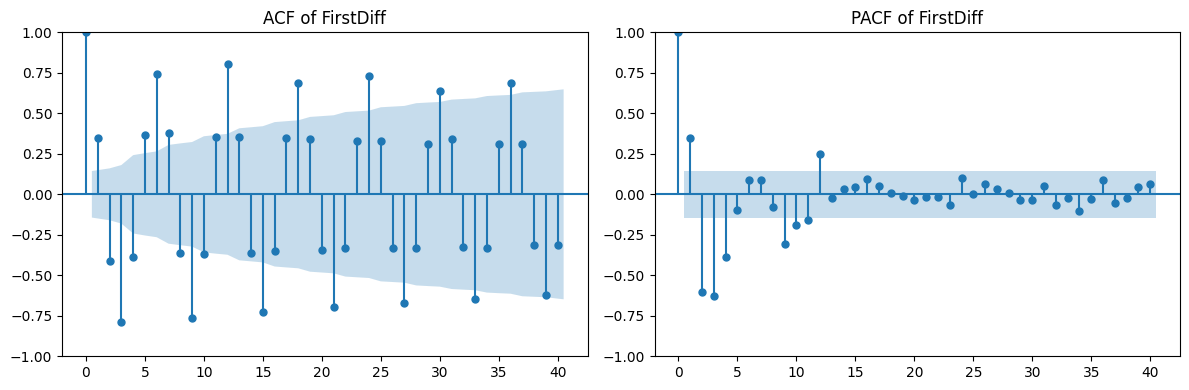

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF
plot_acf(first_diff, ax=axes[0], lags=40)
axes[0].set_title('ACF of FirstDiff')

# Plot PACF
plot_pacf(first_diff, ax=axes[1], lags=40)
axes[1].set_title('PACF of FirstDiff')

plt.tight_layout()
plt.show()

In [34]:
# p = (3,4,9), P = 1 (for P look at multiples of s(12) in PACF)
# ACF gradually decreases instead of a sharp cutoff so its an AR process q = (0, 1), spiks at multiples of 12. Q = (1 , 2 , 3)
# we know 1st difference is necessary for the series so d = 1 and from above graph, acf/pacf plot we can see seasonality exists at lag 12 which means D = 1

In [35]:
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.asfreq('MS')

In [36]:
train_end = datetime(2023, 1, 1)
test_end = datetime(2025, 7, 1)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [ ]:
# CHeck AIC
# Suppress warnings
warnings.filterwarnings("ignore")

# Define the p, d, q parameters to try
p = range(1, 5)
d = range(0, 2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Seasonal parameters (P, D, Q, s)
P = range(0, 2)
D = range(0, 2)
Q = range(0, 4)
s = 12  # Example seasonal period (monthly data)
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

results = []

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(
                train_data,
                order=param,
                seasonal_order=seasonal_param + (s,)
            )
            model_fit = model.fit()

            results.append({
                'order': param,
                'seasonal_order': seasonal_param,
                'aic': model_fit.aic
            })

        except:
            continue

results_df = pd.DataFrame(results)

# Find the best one
best_row = results_df.loc[results_df['aic'].idxmin()]

print("Best SARIMA order:", best_row['order'])
print("Best seasonal order:", best_row['seasonal_order'])
print("Best AIC:", best_row['aic'])

results_df = results_df.sort_values('aic').reset_index(drop=True)


In [ ]:
len(results_df)

382

In [ ]:
results_df.head(50)

,order,seasonal_order,aic
0,"(1, 1, 1)","(0, 1, 3)",748.103350
1,"(1, 1, 1)","(1, 1, 3)",748.715193
2,"(1, 1, 2)","(0, 1, 3)",749.400810
3,"(1, 1, 2)","(1, 1, 3)",749.705852
4,"(2, 1, 1)","(0, 1, 3)",749.760416
5,"(2, 1, 1)","(1, 1, 3)",750.140593
6,"(3, 1, 1)","(0, 1, 3)",750.769537
7,"(3, 1, 1)","(1, 1, 3)",751.132514
8,"(2, 0, 1)","(0, 1, 3)",751.456830
9,"(2, 1, 2)","(0, 1, 3)",751.859047


In [ ]:
results_df[(results_df['order'] == (4, 1, 1)) & (results_df['seasonal_order'] == (0, 1, 3))]

,order,seasonal_order,aic
13,"(4, 1, 1)","(0, 1, 3)",752.637686


In [37]:
model = SARIMAX(train_data, order = (4,1,1), seasonal_order = (0, 1, 3, 12))

In [38]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Model Fitting Time: 5.614789009094238


In [39]:
#summary of the model
print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                       unit   No. Observations:                  157
Model:             SARIMAX(4, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood                -367.319
Date:                                    Thu, 21 Aug 2025   AIC                            752.638
Time:                                            09:13:13   BIC                            779.366
Sample:                                        01-01-2010   HQIC                           763.499
                                             - 01-01-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2985      0.087      3.413      0

In [40]:
#get the predictions and residuals
predictions = model_fit.predict(start = train_end, end = test_end)
predictions = pd.Series(predictions, index=test_data.index)
test_data = test_data['unit']
residuals = test_data - predictions

30


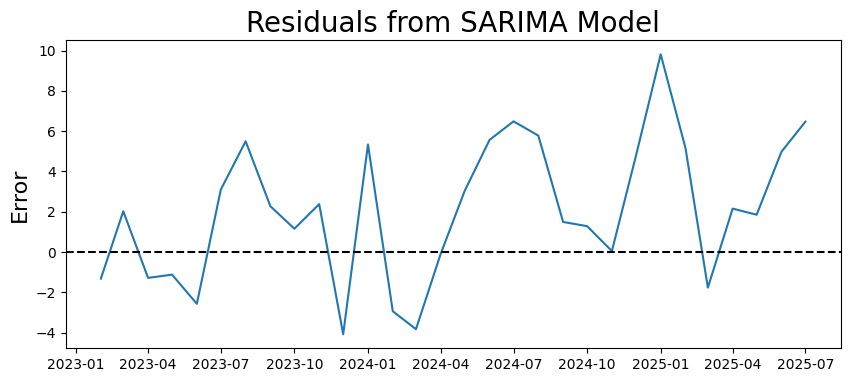

In [41]:
plt.figure(figsize = (10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
print(len(test_data))

In [42]:
perform_adf_test(residuals)

ADF Statistic: -3.737288
p-value: 0.003618


In [43]:
# check if residuals are white noise
ljung = acorr_ljungbox(residuals, lags=[10, 20, 29], return_df=True)
print(ljung)
# high p val means there isnt sufficient evidence to suggest that theyre correlated so its white noise

      lb_stat  lb_pvalue
10   7.483489   0.679147
20  20.941808   0.400565
29  25.793349   0.636512


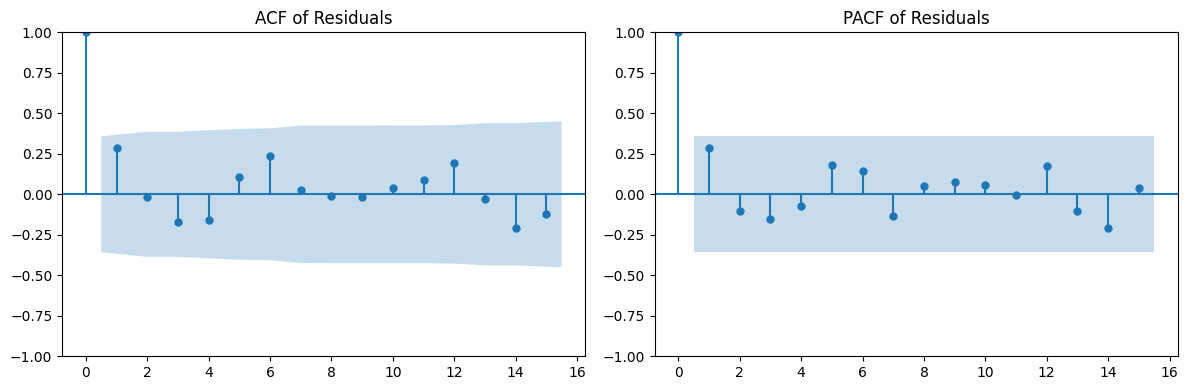

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(residuals, ax = axes[0])
axes[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax = axes[1])
axes[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

In [ ]:
# Constant mean ≈ 0

# Constant variance

# No autocorrelation (ACF/PACF within confidence bands)

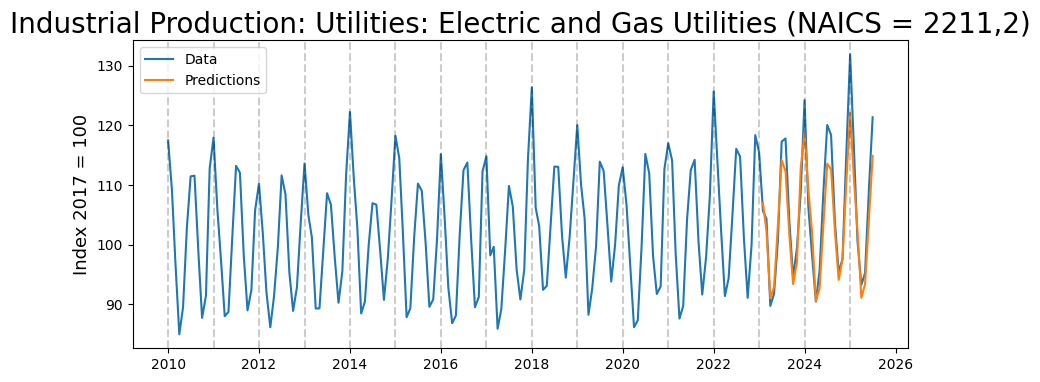

In [45]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'))

plt.title('Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)', fontsize=20)
plt.ylabel('Index 2017 = 100', fontsize = 13)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle= '--', alpha = 0.2)

In [46]:
rmse_test = np.sqrt(mean_squared_error(test_data, predictions))
print("Test RMSE:", rmse_test)


Test RMSE: 3.9967491173488137


In [47]:
# Compare train vs test errors to check for overfitting: if train error is low but test error is high, then overfitting might still be happening.

train_pred = model_fit.fittedvalues

train_pred = pd.Series(train_pred, index = train_data.index)

test_pred = predictions

rmse_train = np.sqrt(mean_squared_error(train_data, train_pred))
rmse_test  = np.sqrt(mean_squared_error(test_data, test_pred))

print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)


Train RMSE: 11.118424361355558
Test RMSE: 3.9967491173488137


In [ ]:
# ---------------------ROLLING-PREDICTIONS--------------------------

In [48]:
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.asfreq('MS')

In [49]:
train_end = datetime(2023, 1, 1)
test_end = datetime(2025, 7, 1)
train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [50]:
rolling_predictions = pd.Series(index=test_data.index, dtype=float)
warnings.filterwarnings("ignore")
for t in test_data.index:
    # train on all data up to t-1
    train = df.loc[:t - timedelta(days=1)]

    model = SARIMAX(train, order=(4,1,1), seasonal_order=(0,1,3,12))
    model_fit = model.fit(disp=False)

    # one-step ahead forecast
    pred = model_fit.predict(start=t, end=t)
    rolling_predictions.loc[t] = pred.iloc[0]

In [51]:
rolling_residuals = test_data["unit"] - rolling_predictions

In [52]:
rolling_residuals

,0
date,
2023-02-01,-1.319353
2023-03-01,2.349711
2023-04-01,-1.975778
2023-05-01,-0.647889
2023-06-01,-2.408596
2023-07-01,4.143221
2023-08-01,4.748698
2023-09-01,0.870940
2023-10-01,0.204353


Text(0, 0.5, 'Error')

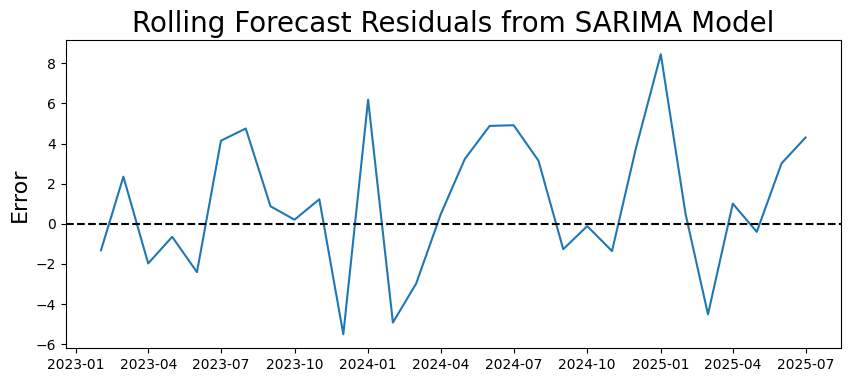

In [53]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [54]:
perform_adf_test(rolling_residuals)

ADF Statistic: -4.962022
p-value: 0.000026


In [55]:
# check if residuals are white noise
ljung = acorr_ljungbox(rolling_residuals, lags=[10, 20, 29], return_df=True)
print(ljung)
# high p val means there isnt sufficient evidence to suggest that theyre correlated so its white noise

      lb_stat  lb_pvalue
10   7.729578   0.655232
20  18.497726   0.554656
29  20.290933   0.883654


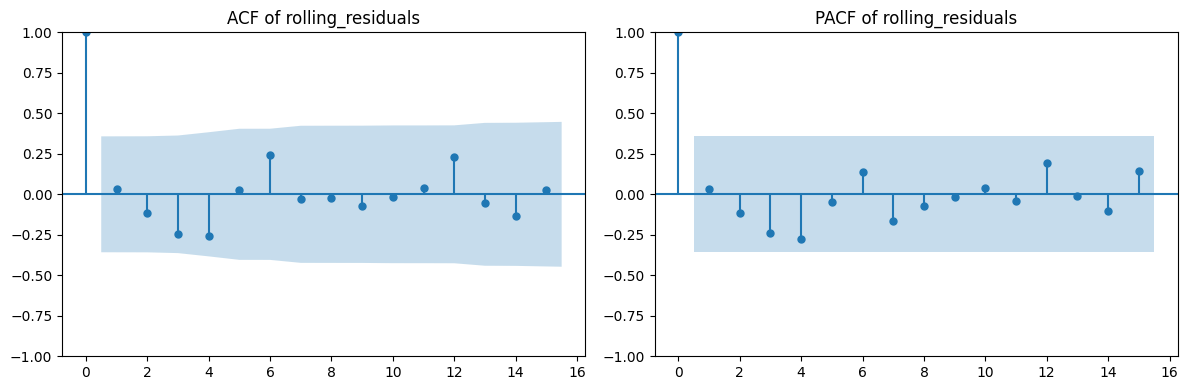

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(rolling_residuals, ax = axes[0])
axes[0].set_title('ACF of rolling_residuals')

plot_pacf(rolling_residuals, ax = axes[1])
axes[1].set_title('PACF of rolling_residuals')

plt.tight_layout()
plt.show()

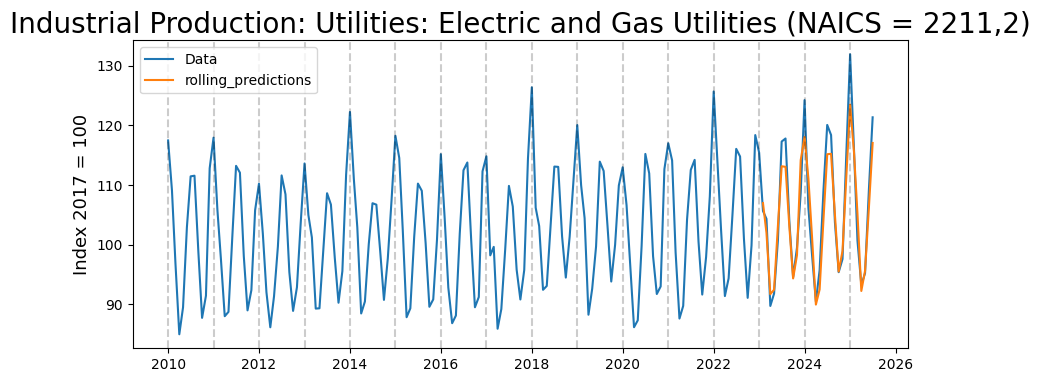

In [57]:
plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(rolling_predictions)

plt.legend(('Data', 'rolling_predictions'))

plt.title('Industrial Production: Utilities: Electric and Gas Utilities (NAICS = 2211,2)', fontsize=20)
plt.ylabel('Index 2017 = 100', fontsize = 13)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color = 'k', linestyle= '--', alpha = 0.2)

In [58]:
rmse_test = np.sqrt(mean_squared_error(test_data, rolling_predictions))
print("Test RMSE:", rmse_test)


Test RMSE: 3.503425602781257


In [59]:
# Compare train vs test errors to check for overfitting: if train error is low but test error is high, then overfitting might still be happening.

train_pred = model_fit.fittedvalues

train_pred = pd.Series(train_pred, index = train_data.index)

test_pred = rolling_predictions

rmse_train = np.sqrt(mean_squared_error(train_data, train_pred))
rmse_test  = np.sqrt(mean_squared_error(test_data, test_pred))

print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)


Train RMSE: 11.121262358639644
Test RMSE: 3.503425602781257


In [ ]:
# future forecasting

In [60]:
n_steps = 12
forecast = model_fit.get_forecast(steps=n_steps)

mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

In [61]:
# you don’t get a Series right away. Instead, you get a PredictionResults object.
# This object contains all the forecast information, including:
# forecast.predicted_mean → the point forecasts (expected / mean of predictive distribution).
# forecast.conf_int() → the confidence intervals (lower & upper bounds).
# forecast.se_mean → the standard error of the forecast.
# forecast.summary_frame() → a nice DataFrame with mean, lower, and upper CI all together.

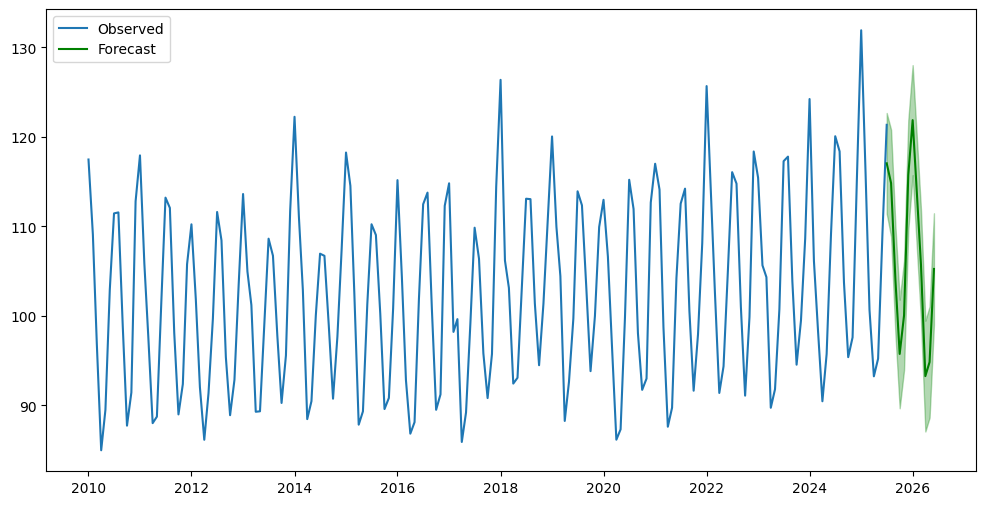

In [62]:
plt.figure(figsize=(12,6))
plt.plot(df["unit"], label="Observed")
plt.plot(mean_forecast.index, mean_forecast, label="Forecast", color = 'green')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color="green", alpha=0.3)
plt.legend()
plt.show()


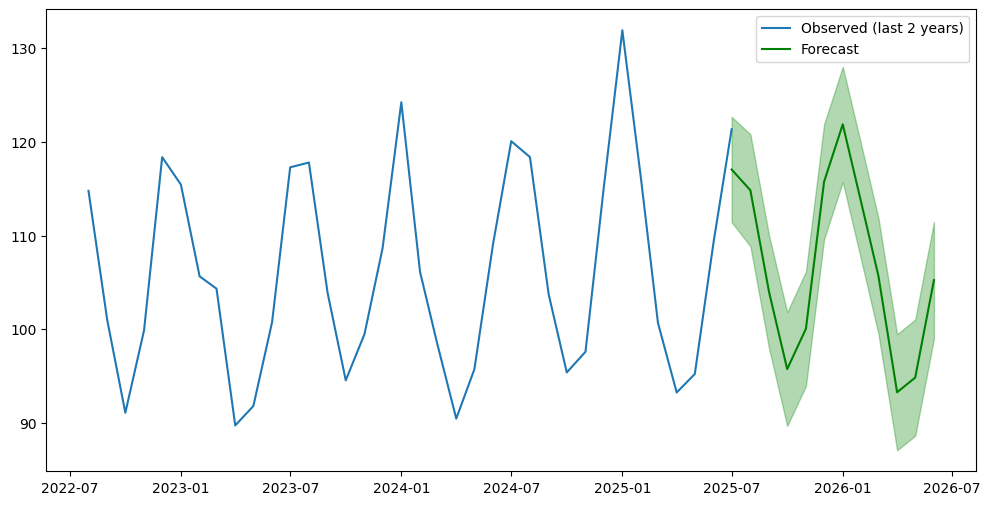

In [63]:
plt.figure(figsize=(12,6))

plt.plot(df["unit"].iloc[-36:], label="Observed (last 2 years)")
plt.plot(mean_forecast.index, mean_forecast, label="Forecast", color="green")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color="green", alpha=0.3)

plt.legend()
plt.show()
